In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle

from itertools import islice
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision
from mpl_toolkits.mplot3d import Axes3D

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)


steps = 10000

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

device = "cuda:0" if torch.cuda.is_available() else "cpu"

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

#torch.set_default_tensor_type(torch.DoubleTensor)


class BioLinear2D(nn.Module):

    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1, out_ring=False):
        super(BioLinear2D, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold
        self.out_fold = out_fold
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0

        #compute in_cor, shape: (in_dim_sqrt, in_dim_sqrt)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        in_dim_sqrt = int(np.sqrt(in_dim_fold))
        out_dim_sqrt = int(np.sqrt(out_dim_fold))
        x = np.linspace(1/(2*in_dim_sqrt), 1-1/(2*in_dim_sqrt), num=in_dim_sqrt)
        X, Y = np.meshgrid(x, x)
        self.in_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)

        # compute out_cor, shape: (out_dim_sqrt, out_dim_sqrt)
        if out_ring:
            thetas = np.linspace(1/(2*out_dim_fold)*2*np.pi, (1-1/(2*out_dim_fold))*2*np.pi, num=out_dim_fold)
            self.out_coordinates = 0.5+torch.tensor(np.transpose(np.array([np.cos(thetas), np.sin(thetas)]))/4, dtype=torch.float)
        else:
            x = np.linspace(1/(2*out_dim_sqrt), 1-1/(2*out_dim_sqrt), num=out_dim_sqrt)
            X, Y = np.meshgrid(x, x)
            self.out_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)


    def forward(self, x):
        return self.linear(x)


class BioMLP2D(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP2D, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth

        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1
        linear_list = []
        for i in range(self.depth):
            if i == 0:
                # for modular addition
                #linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=2))
                # for regression
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1).to(device))
            elif i == self.depth - 1:
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1, out_ring=True).to(device))
            else:
                linear_list.append(BioLinear2D(shp[i], shp[i+1]).to(device))
        self.linears = nn.ModuleList(linear_list)


        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size)).to(device)

        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.5 # distance between two nearby layers
        self.in_perm = nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 30
        self.token_embedding = token_embedding

    def forward(self, x):
        shp = x.shape
        x = x.reshape(shp[0],-1)
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)

        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]

        return x

    def get_linear_layers(self):
        return self.linears

    def get_cc(self, weight_factor=2.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i].to(device)
            dist = torch.sum(torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0)),dim=2).to(device)
            # print("yooo")
            # print(biolinear.linear.weight.device)
            # print(dist.device)
            # print(self.l0)
            cc += torch.mean(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.mean(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.mean(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc

    def swap_weight(self, weights, j, k, swap_type="out"):
        with torch.no_grad():
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))

    def swap_bias(self, biases, j, k):
        with torch.no_grad():
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp

    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron.
        # Note: n layers of weights means n+1 layers of neurons.
        # (incoming, outgoing) * weights + biases are swapped.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            return
            # for images, do not allow input_perm
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm. do not allow input_perm for images
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : (incoming, outgoing) * weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index, score

    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)

    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id[0]:
            self.relocate_ij(i,j)

    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)



/Users/zephyr/anaconda3/envs/modmi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
data_size = 60000
train = torch.utils.data.Subset(train, range(data_size))
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

In [3]:
og_img = train[46][0][0].detach().numpy()
gaussian = np.random.normal(0, 10**0.5, (og_img.shape[0],og_img.shape[1])) 
corrupted_img = og_img + gaussian

In [4]:
corr_tensor = torch.tensor(corrupted_img, dtype=torch.float32)
corr_tensor = corr_tensor.unsqueeze(0).unsqueeze(0)
clean_tensor = torch.tensor(og_img, dtype=torch.float32)
clean_tensor = clean_tensor.unsqueeze(0).unsqueeze(0)

## Training model again bc y not

In [14]:
# train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
# test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
# train_loader = torch.utils.data.DataLoader(train, batch_size=50, shuffle=True)

def accuracy(network, dataset, device, N=2000, batch_size=50):
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    correct = 0
    total = 0
    for x, labels in islice(dataset_loader, N // batch_size):
        #print(x.shape)
        logits = network(x.to(device))
        predicted_labels = torch.argmax(logits, dim=1)
        correct += torch.sum(predicted_labels == labels.to(device))
        total += x.size(0)
    return correct / total

def loss_f(network, dataset, device, N=2000, batch_size=50):
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss = 0
    total = 0
    for x, labels in islice(dataset_loader, N // batch_size):
        logits = network(x.to(device))
        loss += torch.sum((logits-torch.eye(10,)[labels].to(device))**2)
        total += x.size(0)
    return loss / total

train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)

data_size = 60000
train = torch.utils.data.Subset(train, range(data_size))
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

def L2(model):
    L2_ = 0.
    for p in mlp.parameters():
        L2_ += torch.sum(p**2)
    return L2_

def rescale(model, alpha):
    for p in mlp.parameters():
        p.data = alpha * p.data


width = 200
mlp = BioMLP2D(shp=(784,100,100,10))
mlp.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=0.0)

one_hots = torch.eye(10, 10).to(device)

mlp.eval()
print("Initial accuracy: {0:.4f}".format(accuracy(mlp, test, device)))

test_accuracies = []
train_accuracies = []

step = 0
mlp.train()
pbar = tqdm(islice(cycle(train_loader), steps), total=steps)

best_train_loss = 1e4
best_test_loss = 1e4
best_train_acc = 0.
best_test_acc = 0.

log = 200
# lamb = 0.01
# swap_log = 500
plot_log = 500


train_type = 5; #no L1
# train_type = 2; #L1
# train_type = 3: L1 + Local
# train_type = 4: L1 + Swap
# train_type = 5: L1 + Local + Swap
lamb = 0 if train_type==1 else 0.01
swap_log = 200 if train_type >= 4 else float('inf')
weight_factor = 2. if train_type == 3 or train_type == 5 else 0.

for x, label in pbar:

    if step == int(steps/4):
        lamb *= 10
    elif step == int(steps/2):
        lamb *= 10

    mlp.train()
    optimizer.zero_grad()
    loss_train = loss_fn(mlp(x.to(device)), one_hots[label])
    cc = mlp.get_cc(weight_factor, no_penalize_last=True)
    total_loss = loss_train + lamb*cc
    total_loss.backward()
    optimizer.step()

    if step % log == 0:
        with torch.no_grad():
            mlp.eval()
            train_acc = accuracy(mlp, train, device).item()
            test_acc = accuracy(mlp, test, device).item()
            train_loss = loss_f(mlp, train, device).item()
            test_loss = loss_f(mlp, test, device).item()

            if train_acc > best_train_acc:
                best_train_acc = train_acc
            if test_acc > best_test_acc:
                best_test_acc = test_acc
            if train_loss < best_train_loss:
                best_train_loss = train_loss
            if test_loss < best_test_loss:
                best_test_loss = test_loss
            mlp.train()
            pbar.set_description("{:3.3f} | {:3.3f} | {:3.3f} | {:3.3f} | {:3.3f} ".format(train_acc, test_acc, train_loss, test_loss, cc))
    step += 1

    if step % swap_log == 0:
        mlp.relocate()

    # if (step-1) % plot_log == 0:

    #     fig=plt.figure(figsize=(30,15))
    #     ax=fig.add_subplot(projection='3d')

    #     ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
    #     ax.scatter(mlp.linears[0].in_coordinates[:,0].detach().numpy(), mlp.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=train[46][0][0].detach().numpy()[:,::-1].reshape(-1,))
    #     ax.scatter(mlp.linears[1].in_coordinates[:,0].detach().numpy(), mlp.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
    #     ax.scatter(mlp.linears[2].in_coordinates[:,0].detach().numpy(), mlp.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
    #     ax.scatter(mlp.linears[2].out_coordinates[:,0].detach().numpy(), mlp.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
    #     ax.set_zlim(-0.5,5)
    #     ax.set_xlim(-0.2,1.2)
    #     ax.set_ylim(-0.2,1.2)


    #     for ii in range(3):
    #         biolinear = mlp.linears[ii]
    #         p = biolinear.linear.weight.clone()
    #         p_shp = p.shape
    #         p = p/torch.abs(p).max()

    #         for i in range(p_shp[0]):
    #             if i % 20 == 0:
    #                 print(i)
    #             for j in range(p_shp[1]):
    #                 out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
    #                 in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
    #                 plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")


    #     ring = mlp.linears[2].out_coordinates.detach().cpu().numpy()
    #     for i in range(10):
    #         ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(mlp.out_perm.long()[i].detach().cpu().numpy()))


    #     ax.view_init(30,10)

    #     ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

    #     ax.axis('off')

    #     plt.savefig('./results/mnist_noswap/{0:06d}.png'.format(step-1))

    #     plt.show()

torch.save(mlp.state_dict(), 'mnist_bimt_v1.pt')

Initial accuracy: 0.0710


0.962 | 0.958 | 0.100 | 0.110 | 0.014 : 100%|██████████| 10000/10000 [14:41<00:00, 11.34it/s]


## Loading model

In [5]:
mlp = BioMLP2D(shp=(784,100,100,10)).to(device)
mlp.load_state_dict(torch.load('mnist_bimt_v1.pt'))

<All keys matched successfully>

In [6]:
mlp.eval()  # Set the model to evaluation mode
with torch.no_grad():
    original_output = mlp(clean_tensor)
    corr_op = mlp(corr_tensor)
    print(original_output)
    print(corr_op)

tensor([[ 0.0295, -0.0237, -0.0112,  0.0070, -0.0100,  0.0194,  0.0179, -0.0150,
          0.9388, -0.0410]])
tensor([[0.0959, 0.0072, 0.1065, 0.1722, 0.9180, 0.1019, 0.0243, 0.0870, 0.1352,
         0.0859]])


In [7]:
mlp.get_linear_layers()

ModuleList(
  (0): BioLinear2D(
    (linear): Linear(in_features=784, out_features=100, bias=True)
  )
  (1): BioLinear2D(
    (linear): Linear(in_features=100, out_features=100, bias=True)
  )
  (2): BioLinear2D(
    (linear): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [8]:
def extract_activations(layer, input, output):
    return output

activations = []

def hook_fn(module, input, output):
    activations.append(output)

hooks = []

def measure_improvement(patched_logits, original_logits):
    # Compute L2 difference
    difference_L2 = torch.norm(patched_logits - original_logits, p=2).item()
    return difference_L2

# Attach hooks to all BioLinear2D layers
for layer in mlp.get_linear_layers():
    hooks.append(layer.register_forward_hook(hook_fn))

def patch_neuron(activation, neuron_idx, new_value):
    patched_activation = activation.clone()
    # print("To be patched: ", patched_activation[0, neuron_idx])
    # print("patched to:", new_value)
    patched_activation[0, neuron_idx] = new_value
    return patched_activation

mlp.eval() 
# Get activations for clean and corrupted tensors
mlp(clean_tensor)
clean_activations = activations.copy()  # Store activations after passing the clean tensor
activations.clear()
# print(clean_activations)
mlp(corr_tensor)
corrupted_activations = activations  # Store activations after passing the corrupted tensor
# print(corrupted_activations)

# Clear the hooks
for hook in hooks:
    hook.remove()

improvements = []


# patched_act = patch_neuron(corrupted_activations[0], 0, clean_activations[0][0, 0])
# # print()
# current_activations = [a.clone() for a in corrupted_activations]
# current_activations[0] = patched_act

# current_activations[1] = mlp.get_linear_layers()[1](current_activations[0])
# print(current_activations[1])

# current_activations[2] = mlp.get_linear_layers()[2](current_activations[1])
# print(current_activations[2])



# patched_act = patch_neuron(corrupted_activations[1], 50, clean_activations[1][0, 50])
# # print()
# current_activations = [a.clone() for a in corrupted_activations]
# current_activations[1] = patched_act

# current_activations[2] = mlp.get_linear_layers()[2](current_activations[1])
# print(current_activations[2])

# current_activations[2] = mlp.get_linear_layers()[2](current_activations[1])
# print(current_activations[2])

# Iterate through layers
for layer_idx, (clean_act, corrupted_act) in enumerate(zip(clean_activations, corrupted_activations)):
    num_neurons = clean_act.shape[1]
    # print(clean_act.shape)
    for neuron_idx in range(num_neurons):
        # Patch the neuron in the corrupted activations
        patched_act = patch_neuron(corrupted_act, neuron_idx, clean_act[0, neuron_idx])

        # Store the patched activations and keep others as-is
        current_activations = [a.clone() for a in corrupted_activations]
        current_activations[layer_idx] = patched_act

        # print(layer_idx)
        # print(neuron_idx)
        # print(len(current_activations))
        # print(current_activations[1].shape)
        # Forward the patched activations through the subsequent layers
        mlp.eval() 

        for inn_idx, sub_layer in enumerate(mlp.get_linear_layers()[layer_idx+1:]):
            # print(inn_idx+layer_idx)
            current_activations[layer_idx+inn_idx+1] = sub_layer(current_activations[layer_idx+inn_idx])
        # for inner_layer_idx, (subsequent_layer, act) in enumerate(zip(mlp.get_linear_layers()[layer_idx + 1:], current_activations[layer_idx:])):
        #     # print(subsequent_layer)
        #     # print(act.shape)
        #     # print(act)
        #     current_activations[inner_layer_idx+1] = subsequent_layer(act)
        # print("reached here")
        # print(current_activations[-1])
        # break
        
        # # Compute the improvement using your preferred metric
        improvement = measure_improvement(current_activations[-1], original_output)  # Implement measure_improvement as required
        improvements.append((layer_idx, neuron_idx, improvement))
        # break
    # break
# Sort neurons by improvement
sorted_neurons = sorted(improvements, key=lambda x: x[2], reverse=False)


In [9]:
sorted_neurons

[(2, 5, 0.9155564308166504),
 (2, 3, 1.271789789199829),
 (2, 2, 1.2770673036575317),
 (2, 4, 1.277921438217163),
 (2, 1, 1.2779994010925293),
 (2, 7, 1.2784168720245361),
 (2, 6, 1.28246009349823),
 (2, 0, 1.2833834886550903),
 (2, 8, 1.3701205253601074),
 (2, 9, 1.6042603254318237),
 (1, 34, 6.989503383636475),
 (0, 42, 7.052344799041748),
 (1, 46, 7.102789878845215),
 (0, 63, 7.1872406005859375),
 (0, 15, 7.532162189483643),
 (0, 34, 7.583613872528076),
 (0, 57, 7.7080769538879395),
 (0, 52, 7.777517795562744),
 (0, 66, 7.817789077758789),
 (0, 45, 7.900310039520264),
 (0, 67, 7.926629543304443),
 (0, 36, 8.017669677734375),
 (0, 26, 8.05731201171875),
 (0, 23, 8.097450256347656),
 (0, 37, 8.120943069458008),
 (0, 75, 8.173040390014648),
 (0, 74, 8.175633430480957),
 (0, 96, 8.195968627929688),
 (0, 17, 8.206950187683105),
 (0, 55, 8.209715843200684),
 (0, 94, 8.221869468688965),
 (0, 98, 8.221870422363281),
 (0, 3, 8.221871376037598),
 (0, 7, 8.221871376037598),
 (0, 16, 8.22187137

In [40]:
original_output

tensor([[ 0.0295, -0.0237, -0.0112,  0.0070, -0.0100,  0.0194,  0.0179, -0.0150,
          0.9388, -0.0410]])

In [36]:
for i in range(len(corrupted_activations)):
    print(corrupted_activations[i].shape)

torch.Size([1, 100])
torch.Size([1, 100])
torch.Size([1, 10])


In [27]:
current_activations[-1]

tensor([[-0.0489, -1.5229, -1.6244,  1.0009, -1.2121,  4.1177, -0.5779, -0.9510,
         -3.8628, -5.5088]], grad_fn=<AddmmBackward0>)

## Finding sub circuit with activation patching 

### Selecting neurons in each layer

In [13]:
from itertools import groupby
from operator import itemgetter

# for k, g in groupby(sorted_neurons, key=itemgetter(0)):
#     print(list(g))

# Step 1: Sort the tuples
sorted_tuples = sorted(sorted_neurons, key=itemgetter(0, 2))

# print(sorted_tuples)
# Step 2: Group the tuples
grouped_tuples = {k: list(g) for k, g in groupby(sorted_tuples, key=itemgetter(0))}
print(grouped_tuples)
# Step 3: Extract Top 10
top_10_per_group = {k: [x[1] for x in v] for k, v in grouped_tuples.items()}

# Output the result
for key, value in top_10_per_group.items():
    print(f'Group {key}: {value}')


{0: [(0, 42, 7.052344799041748), (0, 63, 7.1872406005859375), (0, 15, 7.532162189483643), (0, 34, 7.583613872528076), (0, 57, 7.7080769538879395), (0, 52, 7.777517795562744), (0, 66, 7.817789077758789), (0, 45, 7.900310039520264), (0, 67, 7.926629543304443), (0, 36, 8.017669677734375), (0, 26, 8.05731201171875), (0, 23, 8.097450256347656), (0, 37, 8.120943069458008), (0, 75, 8.173040390014648), (0, 74, 8.175633430480957), (0, 96, 8.195968627929688), (0, 17, 8.206950187683105), (0, 55, 8.209715843200684), (0, 94, 8.221869468688965), (0, 98, 8.221870422363281), (0, 3, 8.221871376037598), (0, 7, 8.221871376037598), (0, 16, 8.221871376037598), (0, 49, 8.221871376037598), (0, 50, 8.221871376037598), (0, 61, 8.221871376037598), (0, 89, 8.221871376037598), (0, 0, 8.221872329711914), (0, 1, 8.221872329711914), (0, 4, 8.221872329711914), (0, 5, 8.221872329711914), (0, 6, 8.221872329711914), (0, 8, 8.221872329711914), (0, 9, 8.221872329711914), (0, 10, 8.221872329711914), (0, 11, 8.2218723297119

In [34]:
y_values

[7.052344799041748,
 7.1872406005859375,
 7.532162189483643,
 7.583613872528076,
 7.7080769538879395,
 7.777517795562744,
 7.817789077758789,
 7.900310039520264,
 7.926629543304443,
 8.017669677734375,
 8.05731201171875,
 8.097450256347656,
 8.120943069458008,
 8.173040390014648,
 8.175633430480957,
 8.195968627929688,
 8.206950187683105,
 8.209715843200684,
 8.221869468688965,
 8.221870422363281,
 8.221871376037598,
 8.221871376037598,
 8.221871376037598,
 8.221871376037598,
 8.221871376037598,
 8.221871376037598,
 8.221871376037598,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,
 8.221872329711914,

In [31]:
import plotly.express as px

In [71]:
y_values

[0.9155564308166504,
 1.271789789199829,
 1.2770673036575317,
 1.277921438217163,
 1.2779994010925293,
 1.2784168720245361,
 1.28246009349823,
 1.2833834886550903,
 1.3701205253601074,
 1.6042603254318237]

In [88]:
sorted_tuples = sorted(sorted_neurons, key=itemgetter(0, 2))

# Group the tuples by the first value
grouped_tuples = {k: list(g) for k, g in groupby(sorted_tuples, key=itemgetter(0))}

# Create a new figure
# plt.figure(figsize=(10, 6), dpi=80)


# Plot a graph for each group
for key, group in grouped_tuples.items():
    x_values = [t[1] for t in group]
    y_values = [t[2] for t in group]
    
    colors = ['Potentially Part of Circuit' if y < np.mean(y_values)-0.1 else 'Not relevant to task' for y in y_values]
    if key == 2:
        colors = ['Potentially Part of Circuit' if y <= np.mean(y_values)+0.5 else 'Not relevant to task' for y in y_values]
    if key == 1:
        colors = ['Potentially Part of Circuit' if y <= np.mean(y_values) else 'Not relevant to task' for y in y_values]
    fig = px.scatter(x = x_values, y=y_values, color=colors) #, size=[0.001]*len(x_values))
    fig.update_traces(marker=dict(
        size=15,
        line=dict(
            width=1,
            color='DarkSlateGrey'
        )
    ))
    fig.update_xaxes(title_text='Neuron (i)')
    fig.update_yaxes(title_text='Logit Difference (L_corr --> L_clean)')
    fig.update_layout(width=1000, height=700)
    fig.show()
    
    # plt.scatter(x_values, y_values, label=f'Activation Layer 1', marker='o', color= colors)
    # break

# ax = plt.gca()  # Get the current Axes instance
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # Add labels and legend
# plt.xlabel('Neuron (i)')
# plt.ylabel('Logit Difference (L_corr --> L_clean)')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.legend()

# # Show the plot
# plt.show()

In [97]:
mlp.eval()
with torch.no_grad():
    og_op = mlp(clean_tensor)
    clean_activations = activations.copy()

# clean_activations[0].shape

In [98]:
sub_graph_act = [a.clone() for a in clean_activations]

In [99]:
sub_graph_act[0]

tensor([[-1.0029e-02,  1.5637e-02,  1.5209e-02, -4.4920e-03, -4.9013e-03,
          1.7484e-04,  1.5394e-02, -1.1476e-02, -3.3662e-03, -6.1534e-03,
         -2.1722e-04, -1.0151e-03, -9.9426e-03,  1.5655e-03, -6.7513e-03,
          1.9196e+00,  2.0373e-02,  1.7177e+00, -3.0685e-02,  4.7240e-03,
          6.9084e-04, -3.8423e-03,  1.4225e-02,  5.9666e-01, -6.2552e+00,
         -5.1022e+00, -4.6213e+00, -1.1192e-02,  1.6700e-03,  7.2590e-03,
          6.7213e-03,  2.0626e-02, -3.1454e-03, -6.1631e+00,  2.9922e+00,
          9.1194e+00, -9.6821e+00, -2.7015e+00, -1.1963e-04,  2.1343e-02,
         -6.1901e-03,  1.3081e-02, -1.2868e+01,  1.5494e+00, -2.4670e+00,
         -4.4208e+00,  3.0014e+00, -1.2881e+00,  7.2565e+00,  7.8678e-03,
          1.8089e-02, -4.7411e-04,  9.2425e+00,  3.9004e+00, -4.3561e-01,
         -2.5105e+00,  7.4278e+00, -7.3204e+00, -1.5827e-02, -5.0384e-03,
          1.6223e-03, -1.1711e-02,  1.6114e+00, -1.4013e+01,  6.9965e+00,
         -1.7432e-01, -9.0512e+00, -5.

In [59]:
# indices_0 = torch.tensor(top_10_per_group[0])
# zero_tensor = torch.zeros_like(sub_graph_act[0])
# zero_tensor[0, torch.tensor(top_10_per_group[0])] = sub_graph_act[0][0, torch.tensor(top_10_per_group[0])]
# sub_graph_act[0] = zero_tensor
# sub_graph_act[0]

tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   1.9196,   0.0000,   1.7177,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.5967,   0.0000,   0.0000,  -4.6213,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   2.9922,
           0.0000,  -9.6821,  -2.7015,   0.0000,   0.0000,   0.0000,   0.0000,
         -12.8676,   0.0000,   0.0000,  -4.4208,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   9.2425,   0.0000,   0.0000,  -2.5105,
           0.0000,  -7.3204,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
         -14.0134,   0.0000,   0.0000,  -9.0512,  -5.4109,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   1.5151,  -0.5755,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0

In [100]:
for inn_idx, sub_layer in enumerate(mlp.get_linear_layers()[1:]):
    # print(inn_idx+layer_idx)
    zero_tensor = torch.zeros_like(sub_graph_act[inn_idx])
    zero_tensor[0, torch.tensor(top_10_per_group[inn_idx])] = sub_graph_act[inn_idx][0, torch.tensor(top_10_per_group[inn_idx])]
    sub_graph_act[inn_idx] = zero_tensor
    print(sub_graph_act[inn_idx].shape)
    sub_graph_act[inn_idx+1] = sub_layer(sub_graph_act[inn_idx])
    # current_activations[layer_idx+inn_idx+1] = sub_layer(current_activations[layer_idx+inn_idx])

torch.Size([1, 100])
torch.Size([1, 100])


In [101]:
sub_graph_act[-1]

tensor([[-0.0123,  1.4257,  1.3095, -0.6946, -4.2168,  3.3142,  3.7624, -0.1207,
          0.0496,  7.9301]], grad_fn=<AddmmBackward0>)

In [102]:
measure_improvement(sub_graph_act[-1], og_op)

10.547600746154785

In [103]:
og_op

tensor([[ 0.0295, -0.0237, -0.0112,  0.0070, -0.0100,  0.0194,  0.0179, -0.0150,
          0.9388, -0.0410]])

# PLotting the sub circuit for BIMT

In [91]:
def sparsify2circuit_left(wt_tensor, indices_tensor):
    zero_tensor = torch.zeros_like(wt_tensor)
    zero_tensor[indices_tensor, :] = wt_tensor[indices_tensor, :]
    return zero_tensor

def sparsify2circuit_right(wt_tensor, indices_tensor):
    zero_tensor = torch.zeros_like(wt_tensor)
    zero_tensor[:, indices_tensor] = wt_tensor[:, indices_tensor]
    return zero_tensor

In [110]:
# p1 = mlp.linears[0].linear.weight.clone()
# print(p1)
# p1 = sparsify2circuit(p1, torch.tensor(top_10_per_group[0]))
# print(p1)

tensor([[ 1.5841e-06,  1.0293e-04, -5.2665e-05,  ..., -7.1309e-05,
         -1.2346e-05,  5.8521e-05],
        [ 5.2176e-05,  4.5875e-05,  3.8717e-05,  ...,  7.8481e-05,
         -5.5435e-05,  3.8545e-05],
        [ 5.8969e-05,  8.8855e-05, -3.7960e-05,  ...,  2.6912e-04,
          7.6749e-06,  2.7260e-04],
        ...,
        [-5.4452e-06,  4.3320e-05, -2.5032e-04,  ...,  8.6737e-07,
         -5.0136e-05, -7.6672e-05],
        [ 2.0952e-04,  8.1940e-05, -7.6231e-05,  ..., -3.8962e-05,
         -5.1519e-05, -6.9030e-05],
        [ 1.8815e-07, -9.9000e-05, -3.9860e-05,  ...,  1.9849e-04,
         -3.0070e-05, -6.3536e-05]], grad_fn=<CloneBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<CopySlices>)


In [97]:
for ii in range(3):
    biolinear = mlp.linears[ii]
    p = biolinear.linear.weight.clone()
    if ii == 0:
        p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    else:
        p = sparsify2circuit_right(p, torch.tensor(top_10_per_group[ii-1]))
        p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    
    print(p.shape)
    W = p.T.detach().numpy()
    # print(np.mean(np.abs(W)))
    #     # W = linears[ii].linear.weight.T.detach().numpy()
    n_sparsity = (np.abs(W)<np.mean(np.abs(W))).sum()
    print("Percentage Sparsity:", n_sparsity/(W.shape[0]*W.shape[1]))

torch.Size([100, 784])
Percentage Sparsity: 0.9371428571428572
torch.Size([100, 100])
Percentage Sparsity: 0.9842
torch.Size([10, 100])
Percentage Sparsity: 0.966


0
20
40
60
80
0
20
40
60
80
0


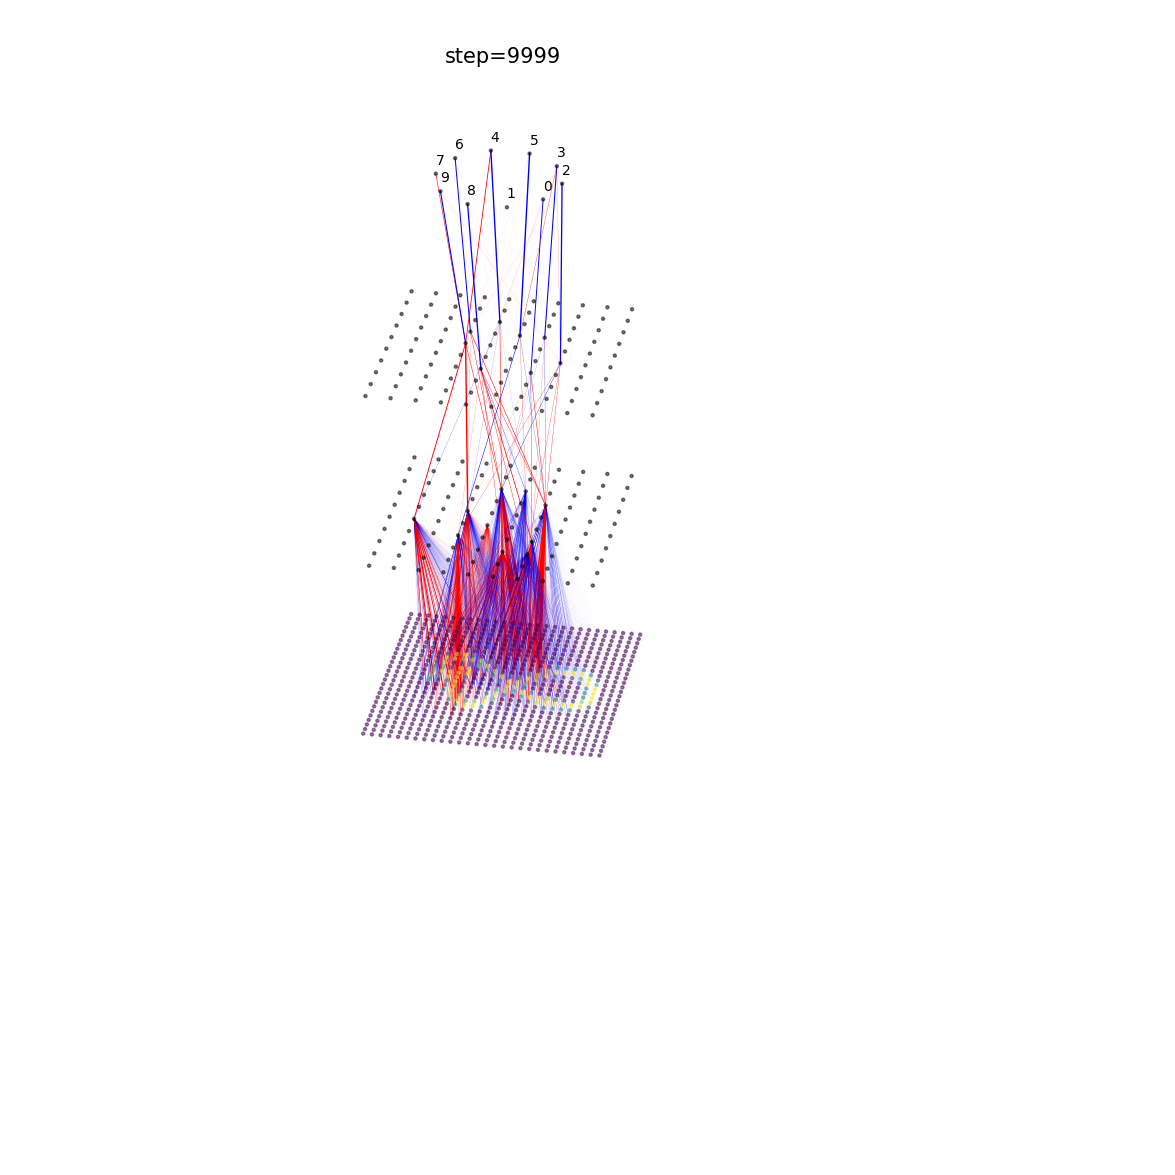

In [118]:

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
ax.scatter(mlp.linears[0].in_coordinates[:,0].detach().numpy(), mlp.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=train[46][0][0].detach().numpy()[:,::-1].reshape(-1,))
ax.scatter(mlp.linears[1].in_coordinates[:,0].detach().numpy(), mlp.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
ax.scatter(mlp.linears[2].in_coordinates[:,0].detach().numpy(), mlp.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
ax.scatter(mlp.linears[2].out_coordinates[:,0].detach().numpy(), mlp.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
ax.set_zlim(-0.5,5)
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)


for ii in range(3):
    biolinear = mlp.linears[ii]
    p = biolinear.linear.weight.clone()
    if ii == 0:
        p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    else:
        p = sparsify2circuit_right(p, torch.tensor(top_10_per_group[ii-1]))
        p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    p_shp = p.shape
    p = p/torch.abs(p).max()

    for i in range(p_shp[0]):
        if i % 20 == 0:
            print(i)
        for j in range(p_shp[1]):
            out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
            in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
            plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")


ring = mlp.linears[2].out_coordinates.detach().cpu().numpy()
for i in range(10):
    ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(mlp.out_perm.long()[i].detach().cpu().numpy()))


ax.view_init(30,10)

ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

ax.axis('off')

# plt.savefig('./results/mnist_noswap/{0:06d}.png'.format(step-1))

plt.show()

# l1 model no nothing load

In [99]:
model2 = BioMLP2D(shp=(784,100,100,10)).to(device)
model2.load_state_dict(torch.load('mnist_no_swap.pt'))

<All keys matched successfully>

## Clean and corrupt

In [100]:
model2.eval()  # Set the model to evaluation mode
with torch.no_grad():
    original_output = model2(clean_tensor)
    corr_op = model2(corr_tensor)
    print(original_output)
    print(corr_op)

tensor([[ 0.0243, -0.0156,  0.0868,  0.0288,  0.0126,  0.0554, -0.0147, -0.0078,
          0.9819, -0.0314]])
tensor([[0.0951, 0.1234, 0.0848, 0.6449, 1.7186, 1.7419, 0.0678, 0.0483, 0.0890,
         0.0999]])


In [101]:
def extract_activations(layer, input, output):
    return output

activations = []

def hook_fn(module, input, output):
    activations.append(output)

hooks = []

def measure_improvement(patched_logits, original_logits):
    # Compute L2 difference
    difference_L2 = torch.norm(patched_logits - original_logits, p=2).item()
    return difference_L2

# Attach hooks to all BioLinear2D layers
for layer in model2.get_linear_layers():
    hooks.append(layer.register_forward_hook(hook_fn))

def patch_neuron(activation, neuron_idx, new_value):
    patched_activation = activation.clone()
    # print("To be patched: ", patched_activation[0, neuron_idx])
    # print("patched to:", new_value)
    patched_activation[0, neuron_idx] = new_value
    return patched_activation

model2.eval() 
# Get activations for clean and corrupted tensors
model2(clean_tensor)
clean_activations = activations.copy()  # Store activations after passing the clean tensor
activations.clear()
# print(clean_activations)
model2(corr_tensor)
corrupted_activations = activations  # Store activations after passing the corrupted tensor
# print(corrupted_activations)

# Clear the hooks
for hook in hooks:
    hook.remove()

improvements = []


# patched_act = patch_neuron(corrupted_activations[0], 0, clean_activations[0][0, 0])
# # print()
# current_activations = [a.clone() for a in corrupted_activations]
# current_activations[0] = patched_act

# current_activations[1] = mlp.get_linear_layers()[1](current_activations[0])
# print(current_activations[1])

# current_activations[2] = mlp.get_linear_layers()[2](current_activations[1])
# print(current_activations[2])



# patched_act = patch_neuron(corrupted_activations[1], 50, clean_activations[1][0, 50])
# # print()
# current_activations = [a.clone() for a in corrupted_activations]
# current_activations[1] = patched_act

# current_activations[2] = mlp.get_linear_layers()[2](current_activations[1])
# print(current_activations[2])

# current_activations[2] = mlp.get_linear_layers()[2](current_activations[1])
# print(current_activations[2])

# Iterate through layers
for layer_idx, (clean_act, corrupted_act) in enumerate(zip(clean_activations, corrupted_activations)):
    num_neurons = clean_act.shape[1]
    # print(clean_act.shape)
    for neuron_idx in range(num_neurons):
        # Patch the neuron in the corrupted activations
        patched_act = patch_neuron(corrupted_act, neuron_idx, clean_act[0, neuron_idx])

        # Store the patched activations and keep others as-is
        current_activations = [a.clone() for a in corrupted_activations]
        current_activations[layer_idx] = patched_act

        # print(layer_idx)
        # print(neuron_idx)
        # print(len(current_activations))
        # print(current_activations[1].shape)
        # Forward the patched activations through the subsequent layers
        model2.eval() 

        for inn_idx, sub_layer in enumerate(model2.get_linear_layers()[layer_idx+1:]):
            # print(inn_idx+layer_idx)
            current_activations[layer_idx+inn_idx+1] = sub_layer(current_activations[layer_idx+inn_idx])
        # for inner_layer_idx, (subsequent_layer, act) in enumerate(zip(mlp.get_linear_layers()[layer_idx + 1:], current_activations[layer_idx:])):
        #     # print(subsequent_layer)
        #     # print(act.shape)
        #     # print(act)
        #     current_activations[inner_layer_idx+1] = subsequent_layer(act)
        # print("reached here")
        # print(current_activations[-1])
        # break
        
        # # Compute the improvement using your preferred metric
        improvement = measure_improvement(current_activations[-1], original_output)  # Implement measure_improvement as required
        improvements.append((layer_idx, neuron_idx, improvement))
        # break
    # break
# Sort neurons by improvement
sorted_neurons = sorted(improvements, key=lambda x: x[2], reverse=False)


In [102]:
sorted_neurons

[(2, 4, 2.0180177688598633),
 (2, 5, 2.034430742263794),
 (2, 8, 2.4871573448181152),
 (2, 3, 2.569749355316162),
 (2, 1, 2.638901710510254),
 (2, 9, 2.639298677444458),
 (2, 6, 2.641273021697998),
 (2, 0, 2.6416120529174805),
 (2, 7, 2.641964912414551),
 (2, 2, 2.6425588130950928),
 (1, 44, 7.059076309204102),
 (1, 75, 10.570867538452148),
 (1, 80, 10.58362102508545),
 (1, 98, 10.828994750976562),
 (1, 31, 10.945387840270996),
 (1, 81, 11.009647369384766),
 (1, 7, 11.021986961364746),
 (1, 9, 11.172467231750488),
 (1, 88, 11.172791481018066),
 (1, 19, 11.186450004577637),
 (1, 26, 11.191346168518066),
 (1, 45, 11.191346168518066),
 (1, 69, 11.191346168518066),
 (1, 71, 11.191346168518066),
 (1, 74, 11.191346168518066),
 (1, 78, 11.191346168518066),
 (1, 86, 11.191346168518066),
 (1, 93, 11.191346168518066),
 (1, 0, 11.191347122192383),
 (1, 3, 11.191347122192383),
 (1, 4, 11.191347122192383),
 (1, 5, 11.191347122192383),
 (1, 11, 11.191347122192383),
 (1, 14, 11.191347122192383),
 (1,

In [103]:
from itertools import groupby
from operator import itemgetter

# for k, g in groupby(sorted_neurons, key=itemgetter(0)):
#     print(list(g))

# Step 1: Sort the tuples
sorted_tuples = sorted(sorted_neurons, key=itemgetter(0, 2))

# print(sorted_tuples)
# Step 2: Group the tuples
grouped_tuples = {k: list(g) for k, g in groupby(sorted_tuples, key=itemgetter(0))}
# print(grouped_tuples)
# Step 3: Extract Top 10
top_10_per_group = {k: [x[1] for x in v[:10]] for k, v in grouped_tuples.items()}

# Output the result
for key, value in top_10_per_group.items():
    print(f'Group {key}: {value}')


Group 0: [32, 28, 9, 99, 33, 56, 66, 15, 39, 20]
Group 1: [44, 75, 80, 98, 31, 81, 7, 9, 88, 19]
Group 2: [4, 5, 8, 3, 1, 9, 6, 0, 7, 2]


In [104]:
model2.eval()
with torch.no_grad():
    og_op = model2(clean_tensor)
    clean_activations = activations.copy()


sub_graph_act = [a.clone() for a in clean_activations]


for inn_idx, sub_layer in enumerate(model2.get_linear_layers()[1:]):
    # print(inn_idx+layer_idx)
    zero_tensor = torch.zeros_like(sub_graph_act[inn_idx])
    zero_tensor[0, torch.tensor(top_10_per_group[inn_idx])] = sub_graph_act[inn_idx][0, torch.tensor(top_10_per_group[inn_idx])]
    sub_graph_act[inn_idx] = zero_tensor
    print(sub_graph_act[inn_idx].shape)
    sub_graph_act[inn_idx+1] = sub_layer(sub_graph_act[inn_idx])

torch.Size([1, 100])
torch.Size([1, 100])


In [105]:
sub_graph_act[-1]

tensor([[ 3.3110, -0.0270, -1.9413,  6.4478,  7.2653, -4.9997,  0.6912, -2.0856,
          3.2770,  5.4149]], grad_fn=<AddmmBackward0>)

In [106]:
measure_improvement(sub_graph_act[-1], og_op)

13.191691398620605

0
20
40
60
80
0
20
40
60
80
0


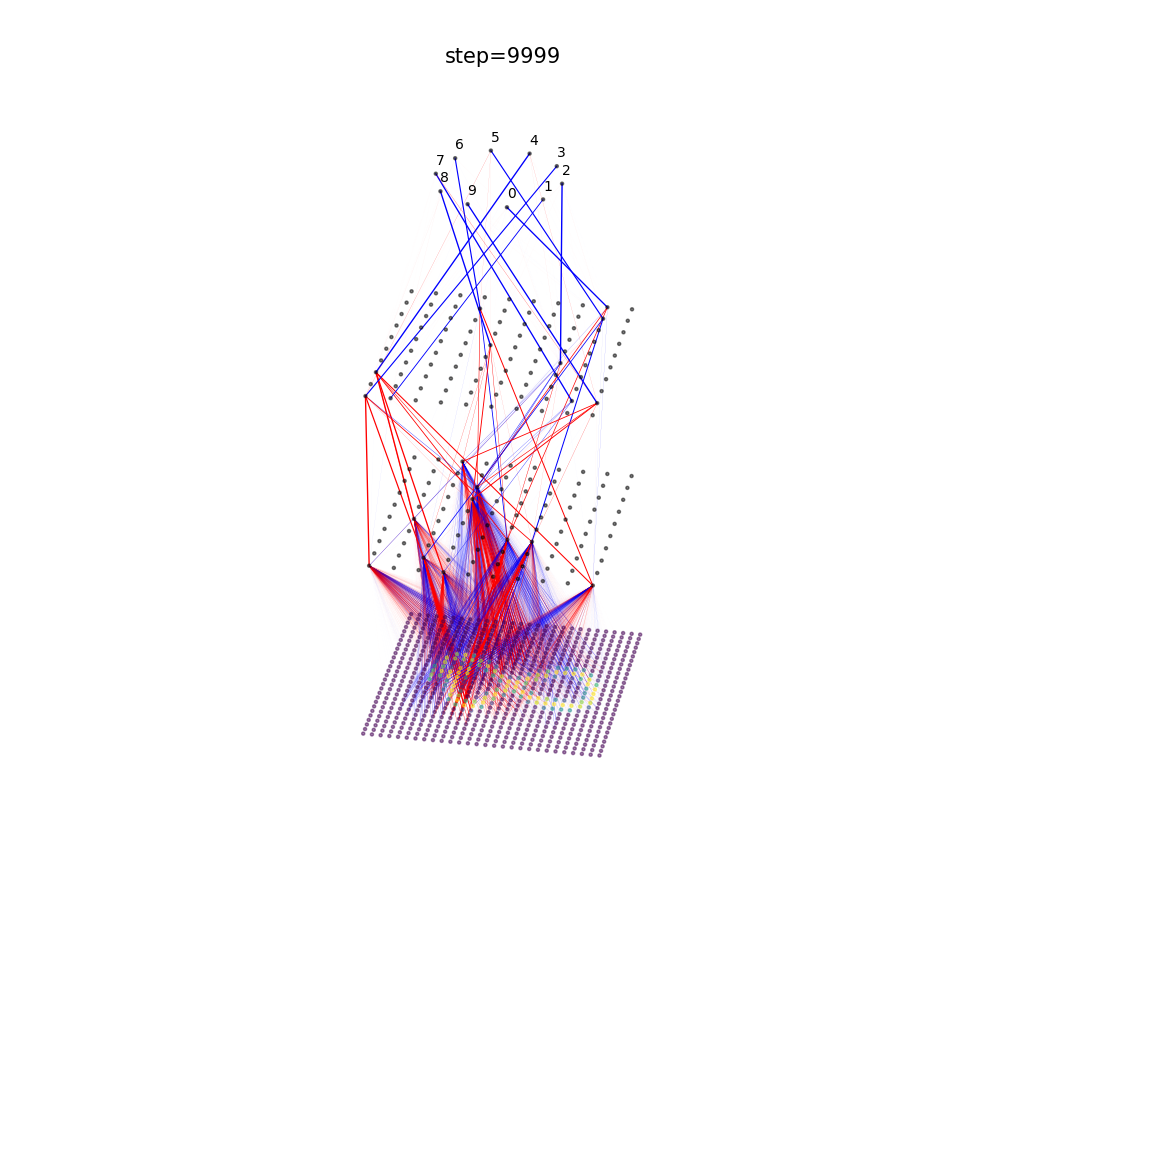

In [125]:

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
ax.scatter(model2.linears[0].in_coordinates[:,0].detach().numpy(), model2.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=train[46][0][0].detach().numpy()[:,::-1].reshape(-1,))
ax.scatter(model2.linears[1].in_coordinates[:,0].detach().numpy(), model2.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
ax.scatter(model2.linears[2].in_coordinates[:,0].detach().numpy(), model2.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
ax.scatter(model2.linears[2].out_coordinates[:,0].detach().numpy(), model2.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
ax.set_zlim(-0.5,5)
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)


for ii in range(3):
    biolinear = model2.linears[ii]
    p = biolinear.linear.weight.clone()
    if ii == 0:
        p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    else:
        p = sparsify2circuit_right(p, torch.tensor(top_10_per_group[ii-1]))
        p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    p_shp = p.shape
    p = p/torch.abs(p).max()

    for i in range(p_shp[0]):
        if i % 20 == 0:
            print(i)
        for j in range(p_shp[1]):
            out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
            in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
            plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")


ring = model2.linears[2].out_coordinates.detach().cpu().numpy()
for i in range(10):
    ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(model2.out_perm.long()[i].detach().cpu().numpy()))


ax.view_init(30,10)

ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

ax.axis('off')

# plt.savefig('./results/mnist_noswap/{0:06d}.png'.format(step-1))

plt.show()

In [107]:
for ii in range(3):
    biolinear = model2.linears[ii]
    p = biolinear.linear.weight.clone()
    if ii == 0:
        p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    else:
        p = sparsify2circuit_right(p, torch.tensor(top_10_per_group[ii-1]))
        p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    
    print(p.shape)
    W = p.T.detach().numpy()
    # print(np.mean(np.abs(W)))
    #     # W = linears[ii].linear.weight.T.detach().numpy()
    n_sparsity = (np.abs(W)<np.mean(np.abs(W))).sum()
    print("Percentage Sparsity:", n_sparsity/(W.shape[0]*W.shape[1]))

torch.Size([100, 784])
Percentage Sparsity: 0.961313775510204
torch.Size([100, 100])
Percentage Sparsity: 0.9916
torch.Size([10, 100])
Percentage Sparsity: 0.982


# Activation Patching Visualization

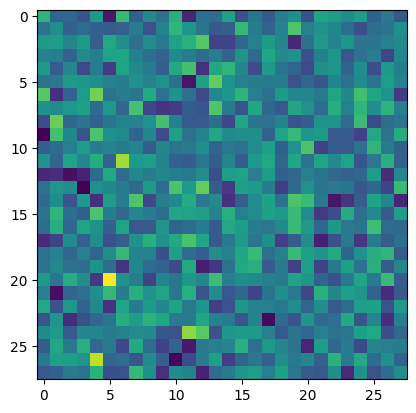

In [129]:
plt.imshow(corrupted_img)

In [132]:
train[46][0][0].detach().numpy().shape

(28, 28)

In [134]:
corrupted_img[:,::-1].reshape(-1,).shape

(784,)

In [131]:
train[46][0][0].detach().numpy()[:,::-1].reshape(-1,).shape

(784,)

In [139]:
biolinear = mlp.linears[1]
p = biolinear.linear.weight.clone()
max_value = torch.max(p)
max_indices = torch.where(p == max_value)
max_indices


(tensor([57]), tensor([47]))

0
20
40
60
80
0
20
40
60
80
0


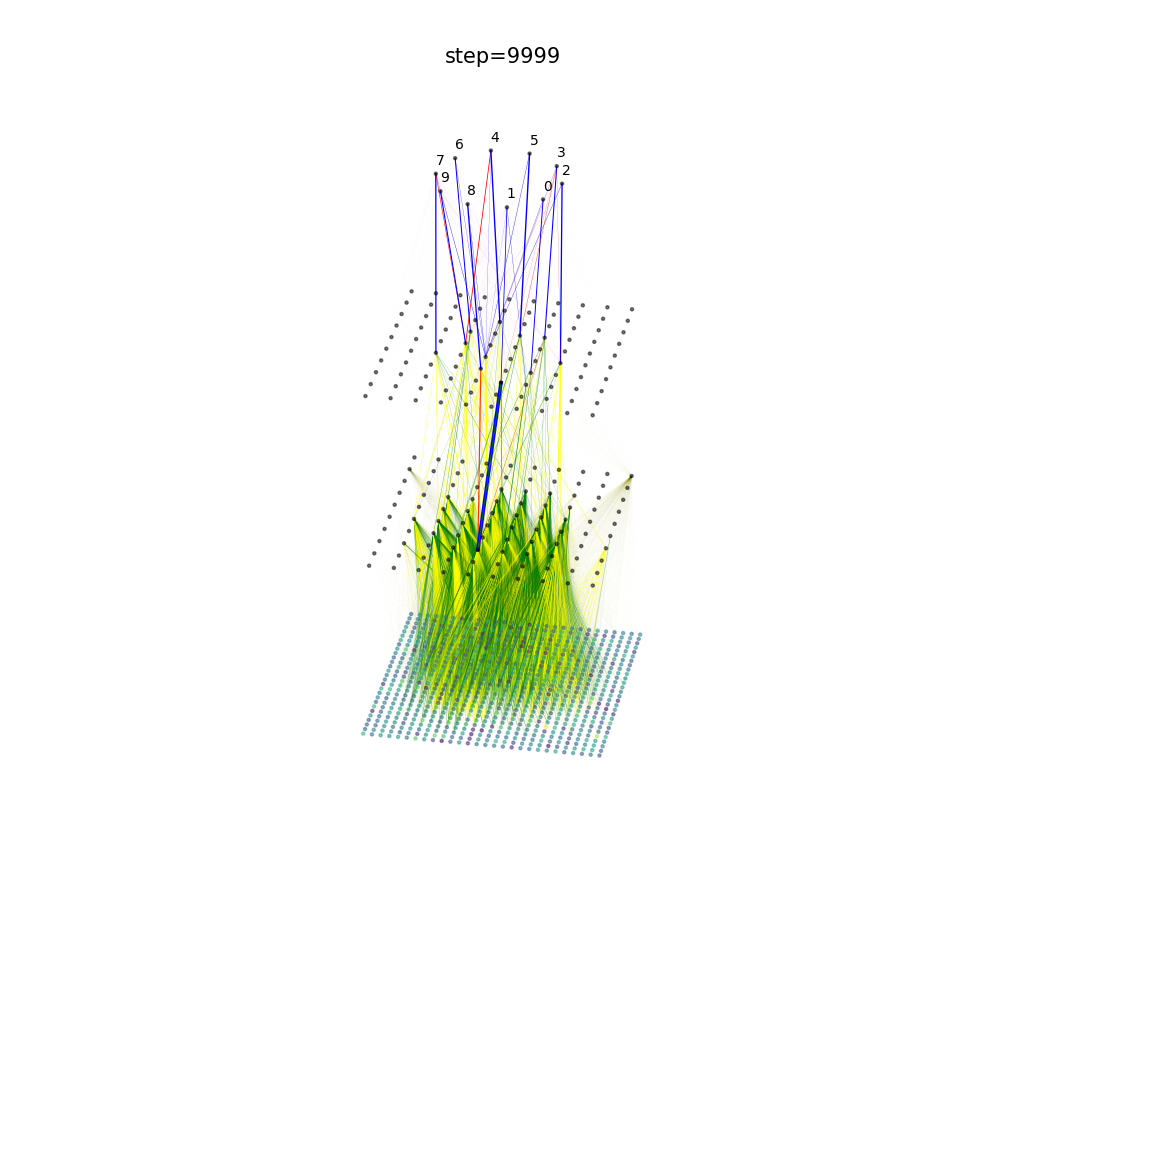

In [143]:

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
ax.scatter(mlp.linears[0].in_coordinates[:,0].detach().numpy(), mlp.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=corrupted_img[:,::-1].reshape(-1,))
ax.scatter(mlp.linears[1].in_coordinates[:,0].detach().numpy(), mlp.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
ax.scatter(mlp.linears[2].in_coordinates[:,0].detach().numpy(), mlp.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
ax.scatter(mlp.linears[2].out_coordinates[:,0].detach().numpy(), mlp.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
ax.set_zlim(-0.5,5)
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)


for ii in range(3):
    biolinear = mlp.linears[ii]
    p = biolinear.linear.weight.clone()
    # if ii == 0:
    #     p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    # else:
    #     p = sparsify2circuit_right(p, torch.tensor(top_10_per_group[ii-1]))
    #     p = sparsify2circuit_left(p, torch.tensor(top_10_per_group[ii]))
    p_shp = p.shape
    p = p/torch.abs(p).max()

    for i in range(p_shp[0]):
        if i % 20 == 0:
            print(i)
        for j in range(p_shp[1]):
            out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
            in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
            if (ii == 1) and (j==47):
                plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=5*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")   
            if (ii == 2):
                plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")   
            else:
                plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="green" if p[i,j]>0 else "yellow")


ring = mlp.linears[2].out_coordinates.detach().cpu().numpy()
for i in range(10):
    ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(mlp.out_perm.long()[i].detach().cpu().numpy()))


ax.view_init(30,10)

ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

ax.axis('off')

# plt.savefig('./results/mnist_noswap/{0:06d}.png'.format(step-1))

plt.show()